<a href="https://colab.research.google.com/github/chanwoo522/Hackathon/blob/main/CNN_Classification_v0_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 임포트

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils

import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import re
import shutil

In [3]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

## 구글 드라이브 마운트

In [4]:
# load image files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 작업 폴더 설정

In [5]:
## directory 설정
cur_dir = os.path.abspath('/content/drive/Shareddrives/aircraft')
image_dir = os.path.join(cur_dir, 'edge')
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.png']

In [6]:
# labeling

Labels = set()

for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    Labels.add(class_name)
Labels = list(Labels)

# ['j10','j11','j15','j16','j20','j31','JL10','j6',
#  'y8g','y9jb','y20','kj2000','bjk005','ch3','wingloong',
#  'xianglong','z9','z18','mig31','su24','su27','su30',
#  'su35','su57','tu95ms','tu142','a50','il38','il20',
#  'f2','e767','ec1','ch47j','p1','f4','f5','fa50','f15',
#  'f16','fa18','f22','f35','a10','b1','b2','c130','p3',
#  'p8','rc135','e737','kc330','u2v']
print(Labels)
img_size = 512

['b-1 lancer', 'f-35 lightning']


In [7]:
## Experiment directory setting

train_dir = os.path.join(cur_dir, 'train_dir')
test_dir = os.path.join(cur_dir, 'test_dir')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for label in Labels:
  label_dir = os.path.join(train_dir, label)
  os.makedirs(label_dir, exist_ok=True)
  label_dir = os.path.join(test_dir, label)
  os.makedirs(label_dir, exist_ok=True)

## 이미지 파일 train, test data로 분리

In [8]:
# practice file separate
cnt = 0
previous_class = ""
image_files.sort()

for image_file in image_files:
  file_name = os.path.splitext(image_file)[0]
  class_name = re.sub('_\d+', '', file_name)
  if class_name == previous_class:
    cnt += 1
  else:
    cnt = 1
  if cnt <= 200:
    for label in Labels:
        if label == class_name:
          cpath = os.path.join(train_dir, label)
          image_path = os.path.join(image_dir, image_file)
          shutil.copy(image_path, cpath)
        else:
          pass
  else:
    for label in Labels:
        if label == class_name:
          cpath = os.path.join(test_dir, label)
          image_path = os.path.join(image_dir, image_file)
          shutil.copy(image_path, cpath)
        else:
          pass
  previous_class = class_name

In [9]:
# Data load and transform
transform0 = transforms.Compose([
                                transforms.Resize((512,512)), 
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),
                                                     (0.5,0.5,0.5))
])

transform1 = transforms.Compose([
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),
                                                     (0.5,0.5,0.5))
])
transform2 = transforms.Compose([
                                transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),
                                                     (0.5,0.5,0.5))
])
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform0)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform0)

# Hyperparameter

"""
추가로 실험해봐야 할 부분
1. epoch / batch size / lr / stepsize 조정
2. crop 조정
"""

EPOCHS = 50       # 40, 150, 300
BATCH_SIZE = 8   # 16, 64, 128

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


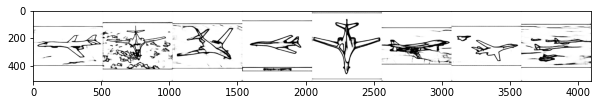

In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
img = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize = (10,7))
plt.imshow(np.transpose(npimg,(1,2,0)))
plt.show()

In [11]:
img.shape

torch.Size([3, 512, 4096])

In [12]:
print(len(Labels))
"""
다른 데이터셋으로 실험 시 반드시 num_classes를 label의 수로 변경
이미지 사이즈 조정 시 출력계층 고치기 self.linear = nn.Linear(64*49, num_classes)
"""
Labels

2


['b-1 lancer', 'f-35 lightning']

In [13]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64*256, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [14]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [16]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()


In [17]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='mean').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [18]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [19]:
for epoch in range(1, EPOCHS + 1):

    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)

    scheduler.step()

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 13765153.0900, Accuracy: 13.00%
[2] Test Loss: 445765.4475, Accuracy: 87.00%
[3] Test Loss: 10377663233392.6406, Accuracy: 13.00%
[4] Test Loss: 11882912885.7600, Accuracy: 13.00%
[5] Test Loss: 490147302473014976.0000, Accuracy: 13.00%
[6] Test Loss: nan, Accuracy: 87.00%
[7] Test Loss: nan, Accuracy: 87.00%
[8] Test Loss: nan, Accuracy: 87.00%
[9] Test Loss: nan, Accuracy: 87.00%
[10] Test Loss: nan, Accuracy: 87.00%
[11] Test Loss: nan, Accuracy: 87.00%
[12] Test Loss: nan, Accuracy: 87.00%
[13] Test Loss: nan, Accuracy: 87.00%
[14] Test Loss: nan, Accuracy: 87.00%
[15] Test Loss: nan, Accuracy: 87.00%
[16] Test Loss: nan, Accuracy: 87.00%
[17] Test Loss: nan, Accuracy: 87.00%
[18] Test Loss: nan, Accuracy: 87.00%
[19] Test Loss: nan, Accuracy: 87.00%
[20] Test Loss: nan, Accuracy: 87.00%
[21] Test Loss: nan, Accuracy: 87.00%
[22] Test Loss: nan, Accuracy: 87.00%
[23] Test Loss: nan, Accuracy: 87.00%
[24] Test Loss: nan, Accuracy: 87.00%
[25] Test Loss: nan, Accuracy:

## 신경망 검사

In [20]:
import torch
import torchvision

dataiter = iter(test_loader)
images, labels = dataiter.next()

## 가중치, 파라미터 확인

In [21]:
print("Model's state dict:")
for param_tensor in model.state_dict():
  print(param_tensor, '\t', model.state_dict()[param_tensor].size())

Model's state dict:
conv1.weight 	 torch.Size([16, 3, 3, 3])
bn1.weight 	 torch.Size([16])
bn1.bias 	 torch.Size([16])
bn1.running_mean 	 torch.Size([16])
bn1.running_var 	 torch.Size([16])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([16, 16, 3, 3])
layer1.0.bn1.weight 	 torch.Size([16])
layer1.0.bn1.bias 	 torch.Size([16])
layer1.0.bn1.running_mean 	 torch.Size([16])
layer1.0.bn1.running_var 	 torch.Size([16])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([16, 16, 3, 3])
layer1.0.bn2.weight 	 torch.Size([16])
layer1.0.bn2.bias 	 torch.Size([16])
layer1.0.bn2.running_mean 	 torch.Size([16])
layer1.0.bn2.running_var 	 torch.Size([16])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([16, 16, 3, 3])
layer1.1.bn1.weight 	 torch.Size([16])
layer1.1.bn1.bias 	 torch.Size([16])
layer1.1.bn1.running_mean 	 torch.Size([16])
layer1.1.bn1.running_var 	 torch.Size([16])
layer1.1.bn1.num_batc

In [22]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
  print(var_name, '\t', optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'momentum_buffer': tensor([[[[-2.0367e+02, -1.9317e+02, -2.0058e+02],
          [-2.1546e+02, -2.1226e+02, -2.2673e+02],
          [-2.4980e+02, -2.5555e+02, -2.7632e+02]],

         [[-2.0367e+02, -1.9317e+02, -2.0058e+02],
          [-2.1546e+02, -2.1226e+02, -2.2673e+02],
          [-2.4980e+02, -2.5555e+02, -2.7632e+02]],

         [[-2.0367e+02, -1.9317e+02, -2.0058e+02],
          [-2.1546e+02, -2.1226e+02, -2.2673e+02],
          [-2.4980e+02, -2.5555e+02, -2.7632e+02]]],


        [[[-1.0575e-02, -2.6706e-02, -2.5344e-02],
          [ 2.8083e-02,  1.1068e-02,  9.9231e-03],
          [ 3.0961e-02,  1.3636e-02,  1.2159e-02]],

         [[-1.0447e-02, -2.7135e-02, -2.5825e-02],
          [ 2.7791e-02,  1.0731e-02,  8.9658e-03],
          [ 3.1241e-02,  1.4064e-02,  1.2071e-02]],

         [[-1.1018e-02, -2.6248e-02, -2.5733e-02],
          [ 2.7696e-02,  1.1208e-02,  9.0837e-03],
          [ 3.1681e-02,  1.3804e-02,  1.1735e-02]]],


        [[

## 모델 저장

In [23]:
# save model

PATH = './model_v0.04.pth'
torch.save(model.state_dict(), PATH)
"""
불러올 땐
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
"""

'\n불러올 땐\nmodel = TheModelClass(*args, **kwargs)\nmodel.load_state_dict(torch.load(PATH))\nmodel.eval()\n'

In [28]:
# construct model on cuda if available

use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(3, 512, 3, stride=1) # in channels, out_channels, kernel_size, stride
        # activation ReLU
        pool1 = nn.MaxPool2d(2) # 6@12*12
        conv2 = nn.Conv2d(512, 1024, 5, stride=1) # in channels, out_channels, kernel_size, stride
        # activation ReLU
        pool2 = nn.MaxPool2d(2) # 16@4*4
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2
        )
        
        fc1 = nn.Linear(32768, 1024)
        # activation ReLU
        fc2 = nn.Linear(1024, 64)
        # activation ReLU
        fc3 = nn.Linear(64, 10)

        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        # gpu로 할당
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) # @16*4*4
        # make linear
        dim = 1
        for d in out.size()[1:]: #16, 4, 4
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [29]:
model2 = CNNClassifier()

In [34]:
learning_rate = 0.01
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

In [35]:
gc.collect()
torch.cuda.empty_cache()

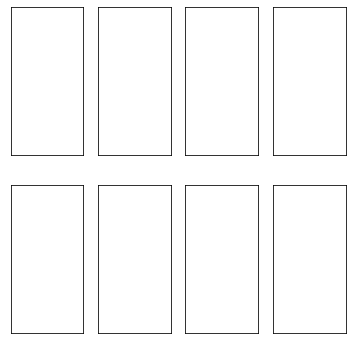

In [37]:
# create figure for plotting
import itertools
row_num = 2
col_num = 4
fig, ax = plt.subplots(row_num, col_num, figsize=(6,6))
for i, j in itertools.product(range(row_num), range(col_num)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False) 
    
trn_loss_list = []
val_loss_list = []
criterion = nn.CrossEntropyLoss()

In [40]:
gc.collect()
torch.cuda.empty_cache()

In [41]:
for epoch in range(EPOCHS):
    trn_loss = 0.0
    for i, data in enumerate(train_loader):
        x, label = data
        if use_cuda:
            x = x.cuda()
            label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = model2(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        train_loss += loss.item()
        # del (memory issue)
        del loss
        del model_output
        
        # 학습과정 출력
        if (i+1) % 10 == 0: # every 10 or 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                test_loss = 0.0
                for j, val in enumerate(test_loader):
                    test_x, test_label = test
                    if use_cuda:
                        test_x = test_x.cuda()
                        test_label = test_label.cuda()
                    test_output = cnn(val_x)
                    t_loss = criterion(test_output, test_label)
                    test_loss += t_loss

            # draw last val dataset
            for k in range(row_num*col_num):
                ii = k//col_num
                jj = k%col_num
                ax[ii,jj].cla() # clear the current axis
                ax[ii,jj].imshow(val_x[k,:].data.cpu().numpy().reshape(28,28), cmap='Greys')
            
            display.clear_output(wait=True)
            display.display(plt.gcf()) # get a reference to a current figure
                
            print("label: {}".format(val_label[:row_num*col_num]))
            print("prediction: {}".format(val_output.argmax(dim=1)[:row_num*col_num]))
            del val_output
            del v_loss
            
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader)
            ))            
            
            train_loss_list.append(train_loss/100)
            test_loss_list.append(test_loss/len(test_loader))
            train_loss = 0.0

RuntimeError: ignored

In [ ]:
model2 = ResNet2().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)